In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import nltk
import pyspark
import spacy
import wordcloud

%matplotlib inline

In [2]:
packages = [
    'com.databricks:spark-xml_2.11:0.4.1',
    'JohnSnowLabs:spark-nlp:1.4.1'
]

spark = pyspark.sql.SparkSession.builder \
    .master('local[4]') \
    .appName('notebook') \
    .config('spark.jars', 'pysparknlp-1.0.0/lib/sparknlp.jar') \
    .config('spark.jars.packages', ','.join(packages)) \
    .getOrCreate()

In [3]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [4]:
nlp = spacy.load('en')

In [5]:
medline_df = spark.read \
    .format("com.databricks.spark.xml") \
    .option("rowTag", "Article") \
    .load("demo-data/medline17n0001.xml") \

In [6]:
medline_df.count()

30000

In [7]:
medline_df.printSchema()

root
 |-- Abstract: struct (nullable = true)
 |    |-- AbstractText: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _Label: string (nullable = true)
 |    |    |    |-- _NlmCategory: string (nullable = true)
 |    |    |    |-- _VALUE: string (nullable = true)
 |-- ArticleTitle: string (nullable = true)
 |-- AuthorList: struct (nullable = true)
 |    |-- Author: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- AffiliationInfo: struct (nullable = true)
 |    |    |    |    |-- Affiliation: string (nullable = true)
 |    |    |    |-- CollectiveName: string (nullable = true)
 |    |    |    |-- ForeName: string (nullable = true)
 |    |    |    |-- Initials: string (nullable = true)
 |    |    |    |-- LastName: string (nullable = true)
 |    |    |    |-- Suffix: string (nullable = true)
 |    |    |    |-- _ValidYN: string (nullable = true)
 |    |-- _CompleteYN: string (nullable = true)
 

In [8]:
text_concat_UDF = pyspark.sql.functions.udf(lambda arr: '\n\n'.join(arr) if arr else None)

In [9]:
texts_df = medline_df \
    .select(
        text_concat_UDF(medline_df["Abstract.AbstractText._VALUE"]).alias("text"),
        medline_df["ArticleTitle"].alias("title")
    ).distinct()    

In [10]:
texts_df.count()

29932

In [11]:
texts_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)



In [12]:
texts_df.show()

+--------------------+--------------------+
|                text|               title|
+--------------------+--------------------+
|                null|Formation of fert...|
|Human glucose 6-p...|Purification of h...|
|The interactions ...|On the interactio...|
|                null|If you like varie...|
|One inbred mouse ...|Molecular nature ...|
|Peptic and chymot...|The amino acid se...|
|The kinetic mecha...|Investigations on...|
|                null|Patient classific...|
|Microcalorimetry ...|Microcalorimetric...|
|The chromatograph...|Chromatographic b...|
|The metabolism of...|Metabolism of del...|
|The management of...|[Past and present...|
|                null|[Periarteritis no...|
|Fast reaction tec...|Mechanistic studi...|
|The nature of mol...|Intermolecular fo...|
|                null|[Clinical charact...|
|A method of isola...|Isolation, chemic...|
|1. Techniques and...|Kinetic studies o...|
|Lipids are separa...|Separation of pes...|
|                null|Proceeding

In [13]:
filtered_df = texts_df \
    .filter("text IS NOT NULL") \
    .filter("title IS NOT NULL") \
    .withColumn("length", pyspark.sql.functions.length(texts_df["text"])) \
    .persist()

In [14]:
filtered_df.count()

15377

In [15]:
filtered_df.show()

+--------------------+--------------------+------+
|                text|               title|length|
+--------------------+--------------------+------+
|Human glucose 6-p...|Purification of h...|   511|
|The interactions ...|On the interactio...|  1131|
|One inbred mouse ...|Molecular nature ...|  1200|
|Peptic and chymot...|The amino acid se...|  1025|
|The kinetic mecha...|Investigations on...|   651|
|Microcalorimetry ...|Microcalorimetric...|   661|
|The chromatograph...|Chromatographic b...|   579|
|The metabolism of...|Metabolism of del...|   871|
|The management of...|[Past and present...|   598|
|Fast reaction tec...|Mechanistic studi...|   830|
|The nature of mol...|Intermolecular fo...|   751|
|A method of isola...|Isolation, chemic...|  1228|
|1. Techniques and...|Kinetic studies o...|  2539|
|Lipids are separa...|Separation of pes...|   504|
|I report further ...|New techniques fo...|  2058|
|A DNA kinase has ...|A deoxyribonuclei...|   752|
|A simple and accu...|Quantitat

In [16]:
sample_df = filtered_df.limit(1000)

In [17]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")

In [18]:
tokenizer_pipeline = pyspark.ml.Pipeline(stages=[document_assembler, tokenizer]).fit(sample_df)

In [19]:
sparknlp_time = %timeit -o sparknlp_num_tokens = tokenizer_pipeline \
    .transform(sample_df) \
    .selectExpr('sum(size(token)) AS num_tokens') \
    .first()['num_tokens']

1.14 s ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
'{:0.4} ms/doc'.format(1000 * sparknlp_time.average / sample_df.count())

'1.136 ms/doc'

In [21]:
sample_texts = sample_df.select('text').rdd.map(lambda r: r[0]).collect()

In [22]:
spacy_time = %timeit -o spacy_num_tokens = sum(\
    len(doc) for doc in nlp.pipe(sample_texts, disable=['tagger', 'parser', 'ner', 'textcat'], n_threads=4))

1.56 s ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
'{:0.4} ms/doc'.format(1000 * spacy_time.average / sample_df.count())

'1.556 ms/doc'

In [24]:
nltk_time = %timeit -o nltk_num_tokens = sum(\
    len(nltk.tokenize.word_tokenize(text)) for text in sample_texts)

1.17 s ± 9.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
'{:0.4} ms/doc'.format(1000 * nltk_time.average / len(sample_texts))

'1.17 ms/doc'

The main contributor to Spark NLP performed detailed benchmarks comparing Spark NLP and spaCy (link to be added)

In [26]:
from pyspark.ml import Pipeline
from pyspark.ml import feature as spark_ft
from pyspark.ml import clustering as spark_cl

In [27]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")
    
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") \
    .setUseAbbreviations(True)
    
tokenizer = Tokenizer() \
  .setInputCols(["sentence"]) \
  .setOutputCol("token")

stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")
    
normalizer = Normalizer() \
    .setInputCols(["stem"]) \
    .setOutputCol("normalized")

finisher = Finisher() \
    .setInputCols(["normalized"]) \
    .setOutputCols(["ntokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(True)

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer, stemmer, normalizer, finisher])

In [28]:
nlp_model = nlp_pipeline.fit(filtered_df)
processed = nlp_model.transform(filtered_df).persist()
processed.count()

15377

In [29]:
stopWords = spark_ft.StopWordsRemover.loadDefaultStopWords('english')
sw_remover = spark_ft.StopWordsRemover(inputCol='ntokens', outputCol='clean_tokens', stopWords=stopWords)

tf = spark_ft.CountVectorizer(vocabSize=500, inputCol='clean_tokens', outputCol='tf')

idf = spark_ft.IDF(minDocFreq=5, inputCol='tf', outputCol='idf')

feature_pipeline = Pipeline(stages=[sw_remover, tf, idf])

In [30]:
feature_model = feature_pipeline.fit(processed)
featurized = feature_model.transform(processed).persist()
featurized.count()

15377

In [31]:
lda = spark_cl.LDA(k=10, featuresCol='idf', seed=123)

In [32]:
lda_model = lda.fit(featurized)

In [33]:
lda_model.describeTopics(maxTermsPerTopic=100).show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[190, 205, 26, 2,...|[0.02333332446572...|
|    1|[269, 50, 23, 342...|[0.02668625316439...|
|    2|[68, 34, 21, 5, 1...|[0.01762884613450...|
|    3|[229, 423, 398, 4...|[0.02724245594106...|
|    4|[8, 338, 230, 168...|[0.03898888582862...|
|    5|[14, 75, 150, 153...|[0.03188585686356...|
|    6|[38, 4, 10, 94, 1...|[0.02507187310853...|
|    7|[4, 1, 152, 120, ...|[0.02530603218789...|
|    8|[104, 450, 91, 20...|[0.02086532821713...|
|    9|[10, 163, 203, 25...|[0.04029549307079...|
+-----+--------------------+--------------------+



In [34]:
tf_model = feature_model.stages[1]

In [35]:
topic_vocabs = {}

for row in lda_model.describeTopics(maxTermsPerTopic=200).collect():
    ((_, topic), (_, terms), (_, weights)) = row.asDict().items()
    topic_vocabs[topic] = [(tf_model.vocabulary[term], wt) for term, wt in zip(terms, weights)]

topic_vocabs

{0: [('transport', 0.02333332446572968),
  ('uptak', 0.023321997251164718),
  ('c', 0.021595236688264376),
  ('ph', 0.017723648848613972),
  ('+', 0.01718960930381554),
  ('glucos', 0.015720491253816894),
  ('degre', 0.014207569256991891),
  ('calcium', 0.013853382414145179),
  ('na', 0.012841407142978298),
  ('fluid', 0.01122925442978577),
  ('temperatur', 0.01064603052715748),
  ('releas', 0.01058505085544561),
  ('accumul', 0.01026008320885678),
  ('viru', 0.0102098607197632),
  ('water', 0.009916801207052038),
  ('proton', 0.00967935589771509),
  ('concentr', 0.009605166407006295),
  ('oxid', 0.009522245450551152),
  ('potassium', 0.009218303347034466),
  ('membran', 0.009154325519656769),
  ('h', 0.008818508306820379),
  ('gradient', 0.008712613149037592),
  ('increas', 0.008536043219521363),
  ('cell', 0.008480525719318635),
  ('rate', 0.00842689858995551),
  ('wa', 0.008253034552535095),
  ('medium', 0.008176115763385556),
  ('min', 0.007882031473301751),
  ('absorpt', 0.0077351

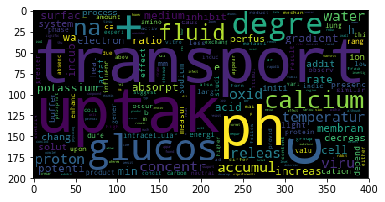

In [36]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[0]))

plt.imshow(wc)
plt.show()

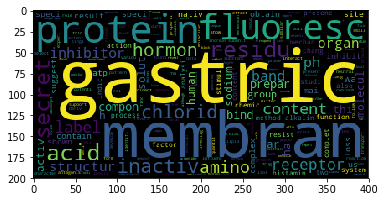

In [37]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[1]))

plt.imshow(wc)
plt.show()

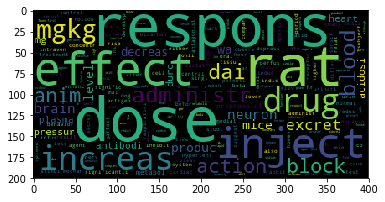

In [38]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[2]))

plt.imshow(wc)
plt.show()

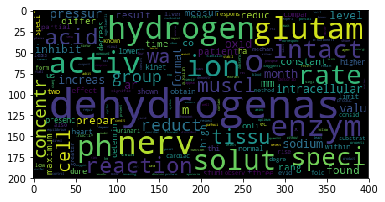

In [39]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[3]))

plt.imshow(wc)
plt.show()

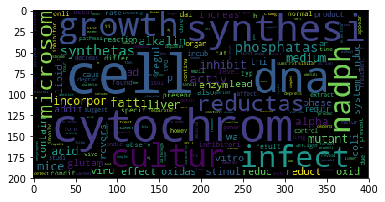

In [40]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[4]))

plt.imshow(wc)
plt.show()

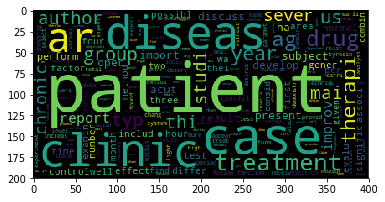

In [41]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[5]))

plt.imshow(wc)
plt.show()

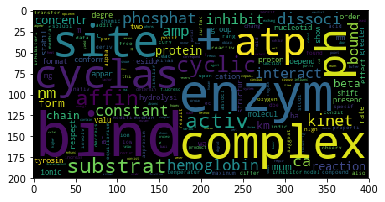

In [42]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[6]))

plt.imshow(wc)
plt.show()

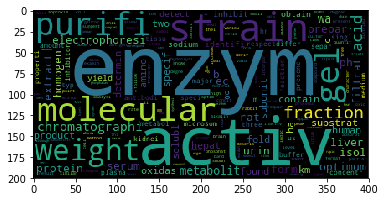

In [43]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[7]))

plt.imshow(wc)
plt.show()

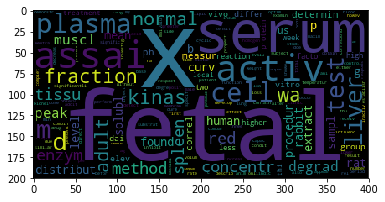

In [44]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[8]))

plt.imshow(wc)
plt.show()

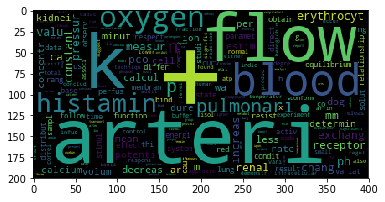

In [45]:
wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(topic_vocabs[9]))

plt.imshow(wc)
plt.show()